# Stock Exploration

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from math import sqrt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
pd.plotting.register_matplotlib_converters()

from vega_datasets import data

import warnings
warnings.filterwarnings("ignore")

## Acquire

In [3]:
stocks = data.stocks()

In [4]:
stocks

,symbol,date,price
0,MSFT,2000-01-01,39.81
1,MSFT,2000-02-01,36.35
2,MSFT,2000-03-01,43.22
3,MSFT,2000-04-01,28.37
4,MSFT,2000-05-01,25.45
...,...,...,...
555,AAPL,2009-11-01,199.91
556,AAPL,2009-12-01,210.73
557,AAPL,2010-01-01,192.06
558,AAPL,2010-02-01,204.62


In [5]:
# to transform such that each symbol is it's own column and each row is one month
stocks = stocks.pivot_table('price', 'date', 'symbol')

In [6]:
stocks

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2000-01-01,25.94,64.56,NaN,100.52,39.81
2000-02-01,28.66,68.87,NaN,92.11,36.35
2000-03-01,33.95,67.00,NaN,106.11,43.22
2000-04-01,31.01,55.19,NaN,99.95,28.37
2000-05-01,21.00,48.31,NaN,96.31,25.45
...,...,...,...,...,...
2009-11-01,199.91,135.91,583.00,125.79,29.27
2009-12-01,210.73,134.52,619.98,130.32,30.34
2010-01-01,192.06,125.41,529.94,121.85,28.05


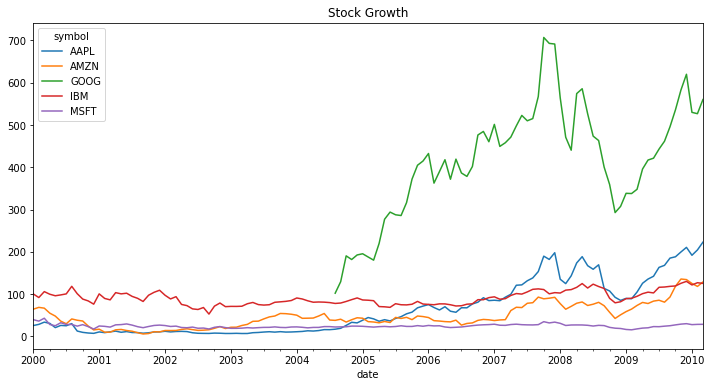

In [7]:
stocks.plot(figsize=(12,6))
plt.title('Stock Growth')
plt.show()

## Prepare IBM
- fbprophet must have the dates labeled as ds and the values labeled as y

In [8]:
ibm = stocks.iloc[:,3:4]

In [9]:
ibm.index.rename('ds', inplace = True)

ibm.columns.rename('', inplace = True)

ibm.rename(columns = {'IBM': 'y'}, inplace = True)

In [10]:
ibm

,y
ds,
2000-01-01,100.52
2000-02-01,92.11
2000-03-01,106.11
2000-04-01,99.95
2000-05-01,96.31
...,...
2009-11-01,125.79
2009-12-01,130.32
2010-01-01,121.85


## Splitting into Train, Validate and Test

In [13]:
train = ibm[:'2007']

In [14]:
validate = ibm['2008']

In [15]:
test = ibm['2009':]

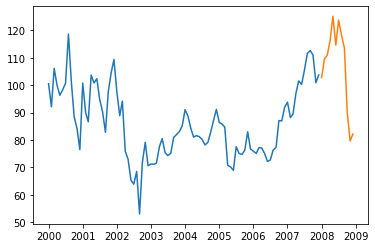

In [16]:
plt.plot(train)
plt.plot(validate)
plt.show()

## Predict

Two ways to predict:

- create a future dataframe and create predictions for those dates. (This is basically your test dataframe)
- use Prophet's cross validation method to predict.

### Future DataFrame

In [17]:
train['cap'] = 200
train['floor'] = 20

# reset index as prophet needs ds to be a column and not an index. 
train = train.reset_index()
validate = validate.reset_index()
test = test.reset_index()

train.head(2)

,ds,y,cap,floor
0,2000-01-01,100.52,200,20
1,2000-02-01,92.11,200,20


### Optimizing Parameters

In [18]:
param_grid = {  
    #if it is too small, the trend will be underfit 
    #if too large, the trend will overfit
    #.05 is default
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    #a large value allows the seasonality to fit large fluctuations
    #a small value shrinks the magnitude of the seasonality
    #10 is default
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial = '1461 days', period = '90 days', horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 14 forecasts with cutoffs between 2004-03-21 00:00:00 and 2007-06-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fed257e6510>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 14 forecasts with cutoffs between 2004-03-21 00:00:00 and 2007-06-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fed24e5f590>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophe

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  16.278649
1                     0.001                     0.10  16.582146
2                     0.001                     1.00  17.194640
3                     0.001                    10.00  17.421831
4                     0.010                     0.01  16.347243
5                     0.010                     0.10  16.869296
6                     0.010                     1.00  17.238603
7                     0.010                    10.00  17.329829
8                     0.100                     0.01  11.822806
9                     0.100                     0.10  11.797652
10                    0.100                     1.00  12.397138
11                    0.100                    10.00  12.380703
12                    0.500                     0.01  10.790036
13                    0.500                     0.10  10.979125
14                    0.500             

### Selecting Best Parameters

In [19]:
m = Prophet(#our data is in months so we will set the follwoing as false
            daily_seasonality = False,
            weekly_seasonality = False,
            #growth=logistic so it won't continue upward or downward indefinitely
            growth = 'logistic',
            changepoint_prior_scale = 0.5,
            seasonality_prior_scale = 0.01)
#Fitting to model
m.fit(train)

In [20]:
#setting the length of predictions for validate
future = m.make_future_dataframe(periods = len(validate))
#setting cap and floor on predictions
future['cap'] = 200
future['floor'] = 20

The futures dataframe will start with the first date in train and end with the last date in validate. Predictions will be made on all the days, but the model only used values of y up to the last date in train.

In [21]:
pd.concat([future.head(2), future.tail(2)])

,ds,cap,floor
0,2000-01-01,200,20
1,2000-02-01,200,20
106,2007-12-12,200,20
107,2007-12-13,200,20


### Making Predictions

In [22]:
forecast = m.predict(future)

In [23]:
#checking returned columns
forecast.columns

Index(['ds', 'trend', 'cap', 'floor', 'yhat_lower', 'yhat_upper',
       'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [25]:
#looking into the last predictions, including the confidence interval
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
103,2007-12-09,108.427149,98.470618,118.052131
104,2007-12-10,108.486886,98.669923,119.205466
105,2007-12-11,108.551475,97.607305,118.305318
106,2007-12-12,108.621569,96.738144,119.198627
107,2007-12-13,108.697758,98.405621,118.919195


### Evaluating the Model

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
eval_df = pd.merge(ibm, forecast[['ds', 'yhat']], how = 'inner', on = 'ds')

In [28]:
rmse = sqrt(mean_squared_error(eval_df.y, eval_df.yhat))
rmse

8.140975362087831

### Visualize Predictions

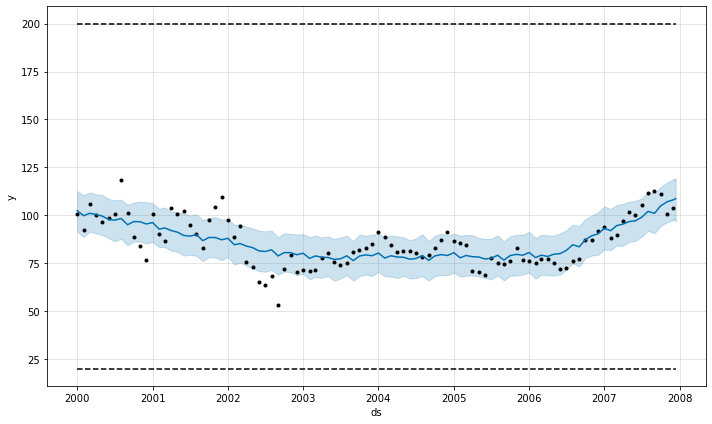

In [29]:
fig1 = m.plot(forecast)

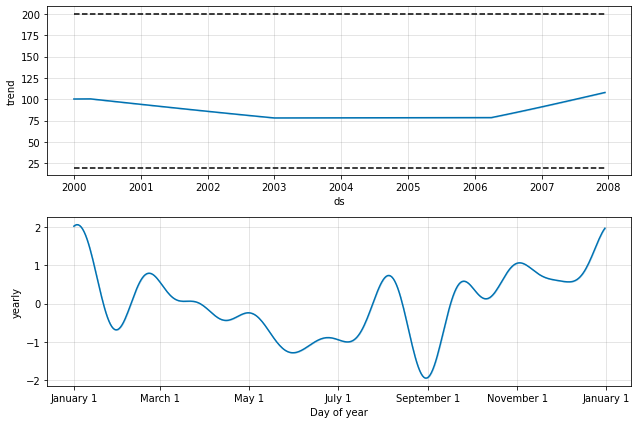

In [30]:
fig2 = m.plot_components(forecast)

### Cross Validation

In [31]:
# format for initial, period and horizon should be in format 
# used by pandas timedelta, which accepts units of days or shorter. 

df_cv = cross_validation(m, 
                         initial = '1461 days', 
                         period = '90 days', 
                         horizon = '180 days', 
                        )

INFO:fbprophet:Making 14 forecasts with cutoffs between 2004-03-21 00:00:00 and 2007-06-04 00:00:00


### Evaluate

In [32]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2004-04-01,86.037022,75.366077,95.733894,81.04,2004-03-21
1,2004-05-01,86.545834,76.561646,97.366545,81.59,2004-03-21
2,2004-06-01,86.779094,75.712563,96.891786,81.19,2004-03-21
3,2004-07-01,87.038174,77.147331,97.574830,80.19,2004-03-21
4,2004-08-01,89.960429,78.915465,99.737695,78.17,2004-03-21
...,...,...,...,...,...,...
79,2007-08-01,92.528823,82.467347,103.096932,111.54,2007-06-04
80,2007-09-01,90.665022,80.772265,101.413333,112.60,2007-06-04
81,2007-10-01,94.183670,82.531689,103.880151,111.00,2007-06-04
82,2007-11-01,96.456202,85.374451,107.033539,100.90,2007-06-04


In [33]:
df_cv.cutoff.value_counts()

2006-03-11    6
2007-03-06    6
2004-12-16    6
2005-12-11    6
2006-12-06    6
2004-09-17    6
2007-06-04    6
2005-09-12    6
2006-09-07    6
2004-06-19    6
2005-06-14    6
2006-06-09    6
2004-03-21    6
2005-03-16    6
Name: cutoff, dtype: int64

In [34]:
df_p = performance_metrics(df_cv)

In [35]:
df_p.head(20)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,21 days,44.169296,6.645998,4.494785,0.060348,0.043117,0.875
1,22 days,43.926403,6.627700,4.454363,0.060301,0.042927,0.875
2,24 days,59.222779,7.695634,5.722832,0.074801,0.051448,0.750
3,26 days,76.157547,8.726829,7.043640,0.080800,0.064743,0.625
4,27 days,102.425091,10.120528,8.458365,0.092678,0.100440,0.500
5,41 days,103.204299,10.158952,8.542724,0.093252,0.100440,0.500
6,43 days,108.724103,10.427085,9.144351,0.100812,0.113183,0.500
7,45 days,107.230884,10.355235,9.016744,0.098731,0.113183,0.500
8,46 days,144.630263,12.026232,10.852566,0.125065,0.132356,0.375
9,47 days,129.229514,11.367916,9.499595,0.109531,0.118002,0.500


In [36]:
df_p[df_p.horizon == "58 days"]

,horizon,mse,rmse,mae,mape,mdape,coverage
18,58 days,122.457056,11.066032,8.22816,0.085709,0.080708,0.75


### Visualize
We can also plot the Mean Absolute Percent Error (MAPE) over the forecast horizon to determine whether our forecast is trustworthy. Here, we use a percentage error instead of the Mean Squared Error (MSE), simply because it is easier to interpret.

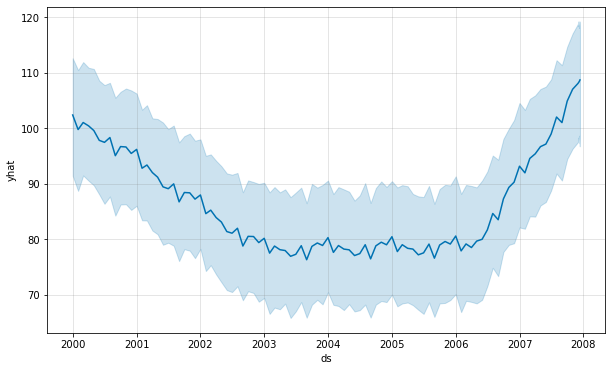

In [37]:
plot_forecast_component(m, forecast, 'yhat')
plt.show()

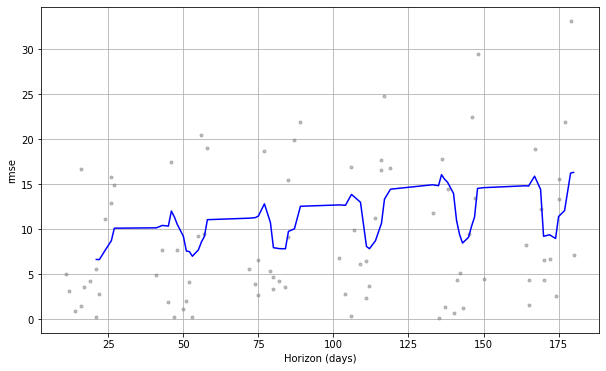

In [38]:
fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

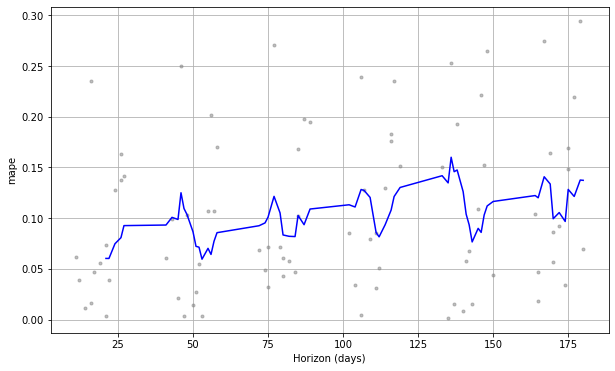

In [39]:
fig3 = plot_cross_validation_metric(df_cv, metric='mape')

In [22]:
apple = stocks.iloc[:,:1]

amazon = stocks.iloc[:, 1:2]

google = stocks.iloc[:,2:3]

ibm = stocks.iloc[:,3:4]

microsoft = stocks.iloc[:,4:5]